## Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

## Importing the dataset

This code is working with biogas values from the **First** reactor.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Paper 13/paper13.csv')
df.head()

,Biomass type,Reactor/feeding,VS (%),pH,OLR (g VS/l.d),HRT (d),T (°C),Reactor Volume (m³),Cumulated biogas volume (L/(g VS))
0,0,0,10.00,7.62,0.6270,19.2,55,0.0500,0.0668
1,0,2,15.30,8.00,3.1702,47.0,37,0.0473,0.6765
2,0,0,4.78,7.25,1.2400,15.0,37,0.0450,0.8227
3,0,0,4.78,7.25,1.7600,15.0,37,0.0450,0.6219
4,0,2,6.36,7.30,3.2000,25.0,35,0.0400,0.5755


## Splitting the data into Test and training data

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Cumulated biogas volume (L/(g VS))'])
y = df['Cumulated biogas volume (L/(g VS))']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Pipeline information

(Since this data does not have missing values, not imputation is required.)

The following transformers will be applied in the pipeline.

Step 1: OneHotEncoding the categorical columns. 

Step 2: Scaling using StandardScaler





In [ ]:
# 1. One Hot Encoding
trf0 = ColumnTransformer(transformers = [
    ('ohe0', OneHotEncoder(drop='first'), ['Biomass type','Reactor/feeding'])
], remainder='passthrough')

In [ ]:
# 2. Scaling
#  Scaling only the temperature column
trf2 = ColumnTransformer([
    ('scale', StandardScaler(), slice(6,12))
], remainder = 'passthrough')

## Creating the pipeline

In [ ]:
pipe = Pipeline([
    ('ohe0', trf0),
    ('scaling', trf2)
])

# Display Pipeline

from sklearn import set_config
set_config(display='diagram')
# Show the steps involved in the pipeline
pipe.named_steps


{'ohe0': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe0', OneHotEncoder(drop='first'),
                                  ['Biomass type', 'Reactor/feeding'])]),
 'scaling': ColumnTransformer(remainder='passthrough',
                   transformers=[('scale', StandardScaler(),
                                  slice(6, 12, None))])}

## Transforming data using pipeline

In [ ]:
# Visualize 
X_trans = pipe.fit(X)
X_train_trans = pipe.transform(X_train)
X_test_trans = pipe.transform(X_test)
X_pd = pd.DataFrame(X_test_trans)
X_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.660635,-0.962779,-0.744619,0.114379,-0.486186,-0.270083,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.542052,-0.526965,-0.020187,-0.529037,2.292019,0.201716,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.173327,-1.398594,-0.605676,-0.529037,-0.486186,0.201716,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.801455,-0.373148,0.160544,-0.207329,-0.208365,1.499164,1.0,0.0,0.0,0.0,0.0,1.0
4,0.566306,1.113748,-0.985996,1.401212,-0.208365,-0.830345,0.0,1.0,0.0,0.0,0.0,0.0


## Building the ANN

Basic model with 2 hidden layers, 32 neurons each.

Also adding dropout layers to counter overfitting.

In [ ]:
# model = Sequential()
# model.add(Dense(15, activation='relu', input_dim= 12))
# # model.add(Dropout(0.5))
# model.add(Dense(15, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(1, activation='linear'))

# model.summary()

## Early Stopping
This is used to detect over fitting and stop further epochs. It is sent as a callback when the model is compiled

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

## Setting the Learning Rate
Using an object of the ADAM class, we can set the learning rate.

In [ ]:
# from tensorflow.keras.optimizers import Adam
# adam = Adam(learning_rate=0.1)

In [ ]:
# model.compile(loss='mse', optimizer='Adam')

## Fitting the model
While fitting the model, it uses a validation set to calculate the accuracy of the data at every epoch.

In [ ]:
# history = model.fit(X_train_trans, y_train, epochs=1000, validation_split=0.20, batch_size=68, callbacks=callback, shuffle=False)
# history = model.fit(X_train_trans, y_train, epochs=1500, validation_split=0.20, batch_size=68, shuffle=False)
# history = model.fit(X_train_trans, y_train, epochs=800, validation_split=0.20, shuffle=False)

## Putting in a loop to automate the number of epochs



In [ ]:
from sklearn.metrics import r2_score

epochs = [100, 250, 500, 1000, 2000]
test_result = []
train_result = []
history = []

for e in epochs:

  ########## Build the model first #############
  model = Sequential()
  model.add(Dense(15, activation='tanh', input_dim= 12, kernel_initializer='glorot_uniform'))
  # model.add(Dropout(0.2))
  model.add(Dense(15, activation='tanh', kernel_initializer='glorot_uniform'))
  # model.add(Dropout(0.5))
  # model.add(Dense(15, activation='elu'))
  model.add(Dense(1, activation='linear'))
  model.summary()

  ######## Compile and fit the model ########
  model.compile(loss='mse', optimizer='Adam')

  history_curr = model.fit(X_train_trans, y_train, epochs=e, validation_split=0.20, shuffle=False)
  history.append(history_curr)
 
  ######## Predicting Results #########
  y_pred = model.predict(X_test_trans)
  test_result.append(r2_score(y_test, y_pred))

  y_pred_train = model.predict(X_train_trans)
  train_result.append(r2_score(y_train, y_pred_train))


Streaming output truncated to the last 5000 lines.
Epoch 511/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.0092 - val_loss: 0.0471
Epoch 512/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0092 - val_loss: 0.0472
Epoch 513/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.0092 - val_loss: 0.0473
Epoch 514/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0091 - val_loss: 0.0474
Epoch 515/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0091 - val_loss: 0.0475
Epoch 516/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - val_loss: 0.0476
Epoch 517/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - val_loss: 0.0477
Epoch 518/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.0091 - val_loss: 0.0478
Epoch 519/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.0090 - val_loss: 0.0479
Epoch 520/1000
3/3 [====================

## Plotting graphs of the training history

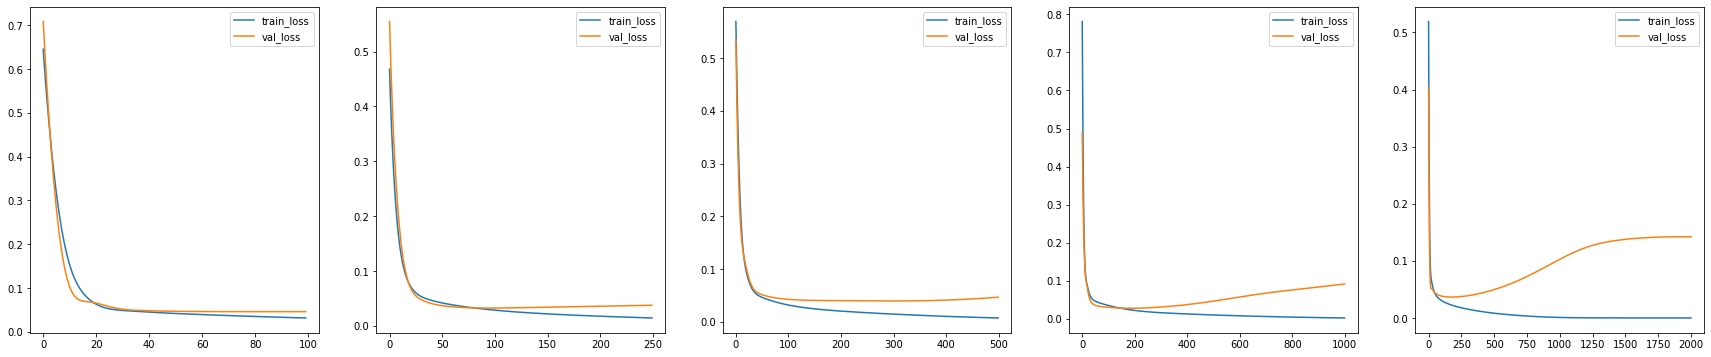

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.legend()
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(30,6) )
idx = 0
for h in history:
  ax[idx].plot(h.history['loss'], label='train_loss')
  ax[idx].plot(h.history['val_loss'], label='val_loss')
  ax[idx].legend()
  idx+=1
  

## Results on the test set

In [ ]:
# from sklearn.metrics import r2_score

# y_pred = model.predict(X_test_trans)
# r2_score(y_test, y_pred)
for epoch,res in zip(epochs, test_result):
  print(epoch,': ',round(res, 4))

100 :  0.5588
250 :  0.6653
500 :  0.4809
1000 :  0.4181
2000 :  0.0892


## Results on training set

In [ ]:
# y_pred_train = model.predict(X_train_trans)
# r2_score(y_train, y_pred_train)

for epoch,res in zip(epochs, train_result):
  print(epoch, ': ',round(res, 4))

100 :  0.5325
250 :  0.739
500 :  0.7933
1000 :  0.7238
2000 :  0.5932


## Testing out a specific epoch
(In between two pre-defined steps)


In [ ]:
########## Build the model first #############
model = Sequential()
model.add(Dense(12, activation='relu', input_dim= 12))
# model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
# model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.summary()

######## Compile and fit the model ########
model.compile(loss='mse', optimizer='Adam')

history_curr = model.fit(X_train_trans, y_train, epochs=250, validation_split=0.20, shuffle=False)
######## Predicting Results #########
y_pred = model.predict(X_test_trans)
print(r2_score(y_test, y_pred))

y_pred_train = model.predict(X_train_trans)
print(r2_score(y_train, y_pred_train))

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 12)                156       
                                                                 
 dense_80 (Dense)            (None, 10)                130       
                                                                 
 dense_81 (Dense)            (None, 1)                 11        
                                                                 
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
3/3 [==============================] - 1s 95ms/step - loss: 0.2371 - val_loss: 0.4810
Epoch 2/250
3/3 [==============================] - 0s 18ms/step - loss: 0.2135 - val_loss: 0.4428
Epoch 3/250
3/3 [==============================] - 0s 21ms/step - loss: 0.1964 - val_loss: 0.4091
Epoch 4/250
3/3 [========

## Printing the weights and biases

In [ ]:
# model.layers[0].get_weights()